In [420]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
import torch
import torch.nn as nn
from matplotlib.colors import Normalize

#### Get the data and visualize it

In [421]:
file_path = 'data/burgers.npy' 
# change path accordingly

In [422]:
with open(file_path, 'rb') as f:
    usol =  np.load(f)

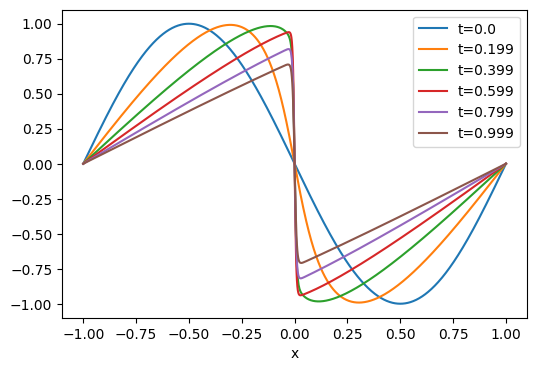

In [423]:
# Visualize some of the data, for some values of t
fig, ax = plt.subplots(1,figsize=(6,4))
for j in [0,199,399,599,799,999]:
    ax.plot(np.linspace(-1, 1, 1000), usol[j,:], label=f't={j/usol.shape[0]}')
ax.set_xlabel('x')
ax.legend()
fig.show()

# the first dimension is t (usol[t,:] is all x at time t)
# second dimension is x 

#### Neural Network Architecture

In [424]:
from torch.nn.init import xavier_normal_, zeros_

class ScalingLayer(nn.Module):
    def __init__(self, scale_init_value=1, bias_init_value=0):
        super().__init__()
        self.scale = nn.Parameter(torch.FloatTensor([scale_init_value]))
        self.bias = nn.Parameter(torch.FloatTensor([bias_init_value]))

    def forward(self, input):
        return input * self.scale + self.bias
    
    
class FNN(nn.Module):
    def __init__(self, dims, hidden_act=nn.Sigmoid(), output_act=nn.Identity(), weight_init=xavier_normal_, bias_init=zeros_):

        super(FNN, self).__init__()

        self.scalinglayer = ScalingLayer()
        self.dims = dims

        input_dim = dims[0]
        output_dim = dims[-1]
        hidden_dims = dims[1:-1]

        self.layers = nn.ModuleList()
        self.layers.append(ScalingLayer())
        in_dim = input_dim
        for out_dim in hidden_dims:
            self.layers.append(nn.Linear(in_dim, out_dim))
            self.layers.append(hidden_act)
            in_dim = out_dim
        self.layers.append(nn.Linear(in_dim, output_dim))
        self.layers.append(output_act)
            
        self.inititialize_weights(weight_init, bias_init)


    def inititialize_weights(self, weight_init, bias_init):
        if weight_init:
            for layer in self.layers:
                if isinstance(layer, nn.Linear):
                    weight_init(layer.weight)
        if bias_init:
            for layer in self.layers:
                if isinstance(layer, nn.Linear):
                    bias_init(layer.bias)

    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [425]:
hidden = [20] * 8

u = FNN(
    dims=[2, *hidden, 1],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)

f = FNN(
    dims=[3, *hidden, 1],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)

### Get training data

In [426]:
# Known viscosity hyperparam
v = 1 / (100 * np.pi)

In [427]:
def get_loss(boundary_points, boundary_targets, collocation_p, train_data, train_targets, lambdas):
    '''
    Computes and returns the boundary, physics and data loss.
    '''
    lambda1, lambda2, lambda3 = lambdas[0], lambdas[1], lambdas[2]
    # boundary loss -------
    u_b = u(boundary_points)
    loss1 = nn.MSELoss()(u_b, boundary_targets)
    

    # Physics loss -------
    u_p = u(collocation_p)
    dudxt = torch.autograd.grad(u_p, collocation_p, torch.ones_like(u_p), create_graph=True)[0]
    dudt = dudxt[:,0]
    dudx = dudxt[:,1]
    
    du2dx2 = torch.autograd.grad(dudxt, collocation_p, 
                                 torch.ones_like(dudxt), create_graph=True)[0][:,1]
    
    f_input = torch.cat([u_p,dudt.reshape(-1,1),dudx.reshape(-1,1)], axis=1)
    f_p = f(f_input)
    
    loss2 = nn.MSELoss()(-dudt.reshape(-1,1) + f_p + v * du2dx2.reshape(-1,1), torch.zeros_like(dudt.reshape(-1,1)))
    
    # Datapoint loss -------
    u_n = u(train_data)
    loss3 = nn.MSELoss()(u_n, train_targets)
    
    loss = lambda1*loss1 + lambda2*loss2  + lambda3*loss3
    return loss, loss1, loss2, loss3

In [428]:
def plot_solution(usol, u, f, mesh_size=10**2):
    '''
    Plot the surrogate solution, slices of the solution and the unknown term.
    '''
    
    # Compute u, dudx and F(u, dudx, dudt) to plot the true, estimated and learned unknown component N_k
    # The unknown component should be: -u * dudx
    x_points = (torch.linspace(-1,1,1000)).reshape(-1,1)
    t_points = (torch.ones_like(x_points)*0.75).reshape(-1,1)
    tx_points = torch.cat([t_points, x_points], axis=1).to(device).requires_grad_(True)
    
    u_plot = u(tx_points)
    
    dudxt_plot = torch.autograd.grad(u_plot, tx_points, torch.ones_like(u_plot), create_graph=True)[0]
    dudt_plot = dudxt_plot[:,0].reshape(-1,1)
    dudx_plot = dudxt_plot[:,1].reshape(-1,1)
    f_input_plot = torch.cat([u_plot, dudt_plot,dudx_plot], axis=1)
    f_plot = f(f_input_plot)
    
    # Compute dudx from the true solution u using finite difference
    # We consider the timestep t=0.75 so that the result is interpretable
    # and it is a timestep without any training data 
    true_u = usol[750,:]
    dudx_upwind = np.zeros((1000,1))
    
    dx = 2 / 1000
    for i in range(1, true_u.shape[0]-1):
            if true_u[i] >= 0:
                    dudx_upwind[i] = (true_u[i] - true_u[i-1]) / dx
            else:
                    dudx_upwind[i] = (true_u[i+1] - true_u[i]) / dx
    
    with torch.no_grad():
            # Get a meshgrid of points to display an image of the solution u in the
            # domain x=[-1,1] and t=[0,1]
            t_phys = np.linspace(0, 1, mesh_size)
            x_phys = np.linspace(-1, 1, mesh_size)
            x_mesh, t_mesh = np.meshgrid(x_phys, t_phys)

            coordinates = np.vstack((t_mesh.flatten(), x_mesh.flatten())).T
            coordinates = torch.Tensor(coordinates).to(device)
            
            u_p = u(coordinates).detach().cpu().numpy()
            u_mesh = u_p.reshape(x_mesh.shape)

            data_min = np.min(u_p)
            data_max = np.max(u_p)

            # Contour plot
            fig, ax = plt.subplots(2,2,figsize=(12,6))
            norm = Normalize(vmin=data_min, vmax=data_max)
            img = ax[0,0].imshow(u_mesh.T, cmap='viridis', 
                                 aspect='auto', 
                                 extent=[0, 1, 1, -1])
            fig.colorbar(img, ax=ax[0,0])

            ax[0,0].set_xlabel('t')
            ax[0,0].set_ylabel('x')
            ax[0,0].set_title('Contour plot of the Viscous Burgers Equation Approximation')
            
            # Slices
            # Visualize some of u predictions, for some values of t
            colors = ['royalblue', 'forestgreen', 'darkorange', 'firebrick']
            for i,(j,k) in enumerate(zip([0,500,750,999], [0,50,75,99])):
                ax[0,1].plot(np.linspace(-1, 1, 1000), usol[j,:], 
                             label=f't={j/usol.shape[0]}', color=colors[i])
                ax[0,1].plot(np.linspace(-1, 1, 100), 
                             u_mesh[k,:], linestyle='--', color=colors[i])
            ax[0,1].set_xlabel('x')
            ax[0,1].legend()
            fig.show()
            
            # plot the unknown term learned by F vs the true interaction
            expected = -(u_plot * dudx_plot).detach().cpu().numpy()
            ax[1,0].plot(np.linspace(-0.25, 0.25, 250), expected[375:625], label='Expected unknown')
            ax[1,0].plot(np.linspace(-0.25, 0.25, 250), f_plot.detach().cpu().numpy()[375:625], label='F', linestyle='--')
            ax[1,0].plot(np.linspace(-0.25, 0.25, 250), (-true_u.reshape(-1,1)*dudx_upwind)[375:625], label='True unknown')
            ax[1,0].legend()
            ax[1,0].set_title('Unknown term at time t=0.75')

            
            plt.show()
            return fig
    

In [429]:
class SparseBurger(torch.nn.Module):
    def __init__(self, nu):
        super(SparseBurger, self).__init__()
        self.nu = nu
    
    def forward(self, X, u):

        d2udxt = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True)[0]
        u_t = d2udxt[:,0:1]
        u_x = d2udxt[:,1:2]

        u_xx = torch.autograd.grad(d2udxt, X, torch.ones_like(d2udxt), create_graph=True)[0][:,1:2]

        return u_t - self.nu*u_xx

N = SparseBurger(v)

In [430]:
from DataGenerators import sample_collocation_points
Xc = sample_collocation_points(10000, 2, [0, -1], [1, 1])

In [431]:
import sys
sys.path.append('../../utils')
from UPINN import UPINN

class UPINN_burger(UPINN):
    
    def F_input(self, X, U):
        dudxt = torch.autograd.grad(U, X, torch.ones_like(U), create_graph=True)[0]
        u_t = dudxt[:,0:1]
        u_x = dudxt[:,1:2]
        return torch.cat((U, u_t, u_x), dim=-1)

    def get_loss(self):
        bc_loss = self.bc_loss()
        data_loss = self.data_loss()
        pde_loss = self.pde_loss()
        loss = bc_loss + data_loss + pde_loss
        return loss, bc_loss, data_loss, pde_loss


# model = UPINN_burger(u, N, f, data_points=(Xd, Ud), boundary_points=(boundary_points, boundary_targets), collocation_points=Xc) 

In [432]:
# adam = torch.optim.Adam(model.parameters(), lr = 2e-2)
# model.optimizer = adam
# model.train_loop(3000)


In [433]:
# model.to('cuda')
# plot_solution(usol, u, f)

In [434]:
Xd = Xd.to(device)
Ud = Ud.to(device)
Xc = Xc.to(device)
Xc.requires_grad_(True)

tensor([[ 0.0000, -1.0000],
        [ 0.5000,  0.0000],
        [ 0.7500, -0.5000],
        ...,
        [ 0.8171,  0.3429],
        [ 0.5671, -0.1571],
        [ 0.0671,  0.8429]], device='cuda:0', requires_grad=True)

In [435]:
# Initial condition
N_ic = N_bc = 100
x0 = torch.linspace(-1, 1, N_ic)
X0, U0 = torch.stack((torch.zeros_like(x0), x0), dim=-1), -torch.sin(torch.pi * x0).reshape(-1, 1)

# Boundary condition
t_bc = torch.linspace(0, 1, N_bc)
XL, XR = torch.stack((t_bc, -torch.ones_like(t_bc)), dim=-1), torch.stack((t_bc, torch.ones_like(t_bc)), dim=-1)
U_bc = torch.zeros_like(t_bc).reshape(-1, 1)

# All boundary conditions
Xbc = torch.cat((X0, XL, XR), dim=0)
Ubc = torch.cat((U0, U_bc, U_bc), dim=0)

Xbc = Xbc.to(device)
Ubc = Ubc.to(device)

In [436]:
lr = 2e-2
optimizer = torch.optim.Adam([*u.parameters(), *f.parameters()], lr=lr) # if you use a shared optimizer
# lr_u = 2e-2 #  2e-2
# lr_f = 3e-2 #  3e-2
# optimizer_u = torch.optim.Adam(u.parameters(), lr=lr_u)
# optimizer_f = torch.optim.Adam(f.parameters(), lr=lr_f)

phys_losses = []
losses = []

total_itr = 10001


for i in range(total_itr):
    optimizer.zero_grad()
    # optimizer_u.zero_grad()
    # optimizer_f.zero_grad()
    
    def closure():
        tot_loss, loss1, loss2, loss3 = get_loss(Xbc, Ubc, 
                                                         Xc, 
                                                         Xd, Ud,
                                                        lambdas=(1, 1, 1)) # 9e0, 2e1, 5e0
        tot_loss.backward()
        return tot_loss

    optimizer.step(closure)
    # optimizer_u.step()
    # optimizer_f.step()
    
    if i% 1000 == 0:
        # print(f'[{i}/{total_itr}] Boundary L: {loss1.item()}, Phys L: {loss2.item()}, Data L: {loss3.item()}')
        plot_solution(usol, u, f)


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
# Save models
torch.save(u.state_dict(), './u_burgers_good.pt')
torch.save(f.state_dict(), './f_burgers_good.pt')

#### Use LBFGS optimizer

In [ ]:
from torch.optim import LBFGS
lbfgs_optim = LBFGS([*u.parameters(), *f.parameters()], history_size=20, max_iter=10)

In [ ]:
def closure():
    lbfgs_optim.zero_grad()
    tot_loss, _, _, _ = get_loss(boundary_points, boundary_targets, 
                                    collocation_p, 
                                    train_data, train_targets,
                                    lambdas=(3e0, 9e0, 5e0)) # 9e0, 2e1, 5e0 # 
    tot_loss.backward()
    return tot_loss

[                    ] 0%[0/10001]


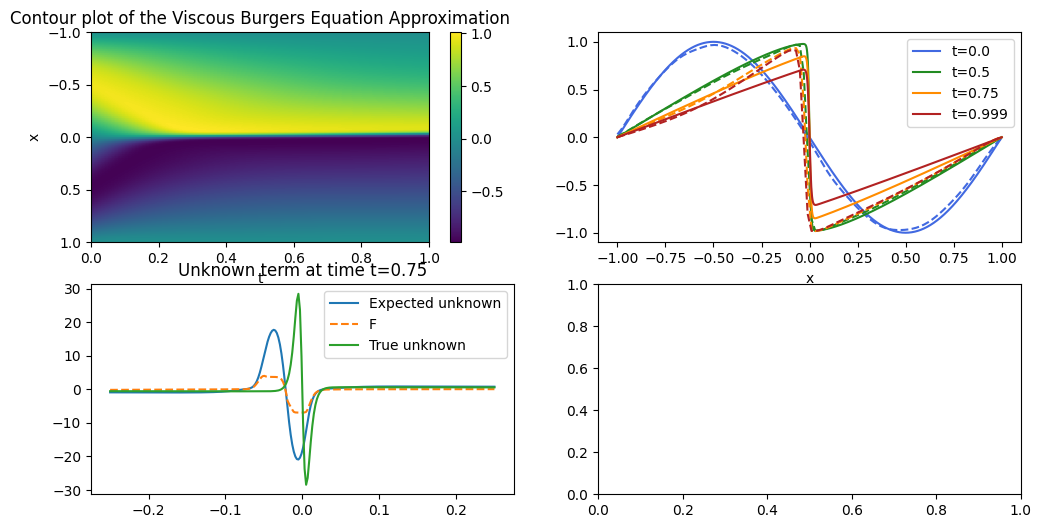

[=                   ] 4%[500/10001]


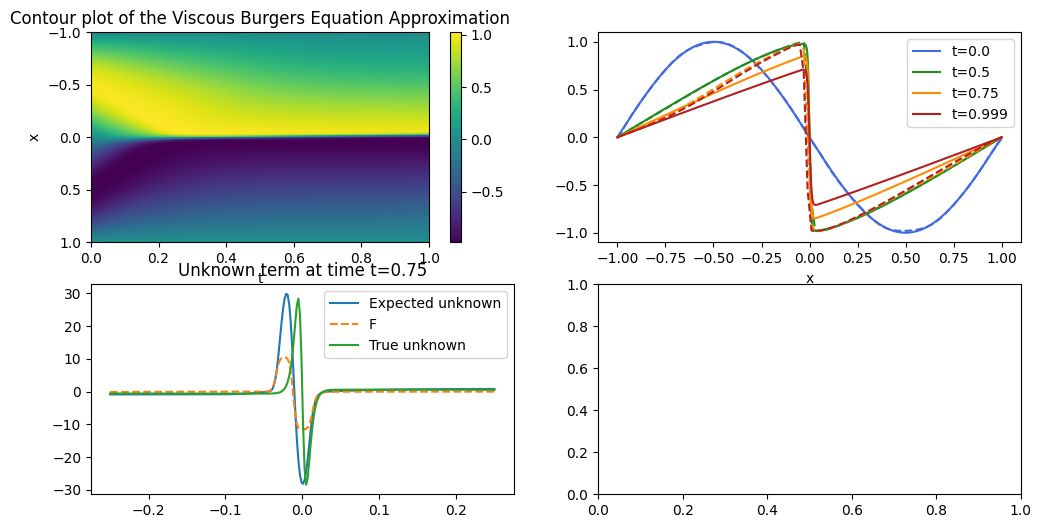

[==                  ] 9%[1000/10001]


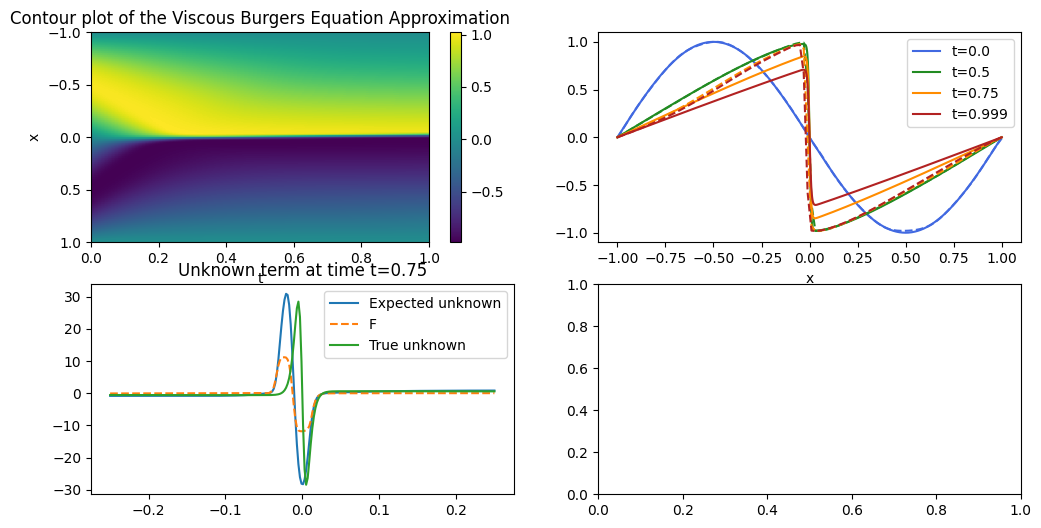

[===                 ] 14%[1500/10001]


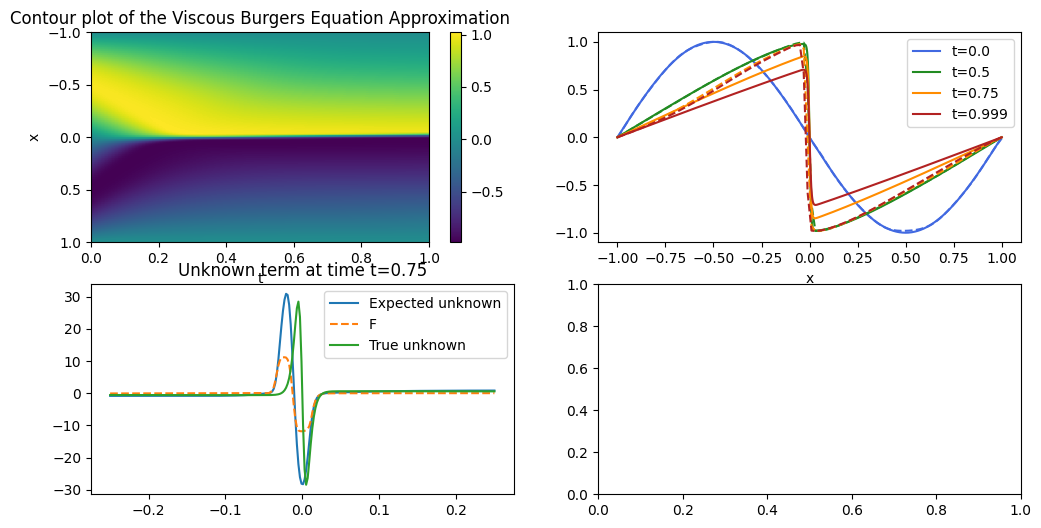

[====                ] 19%[2000/10001]


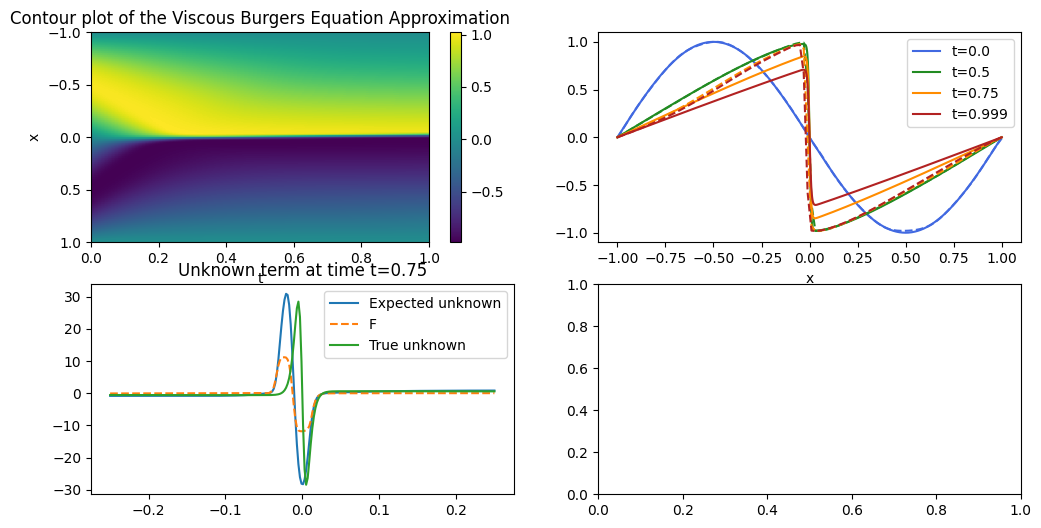

[=====               ] 24%[2500/10001]


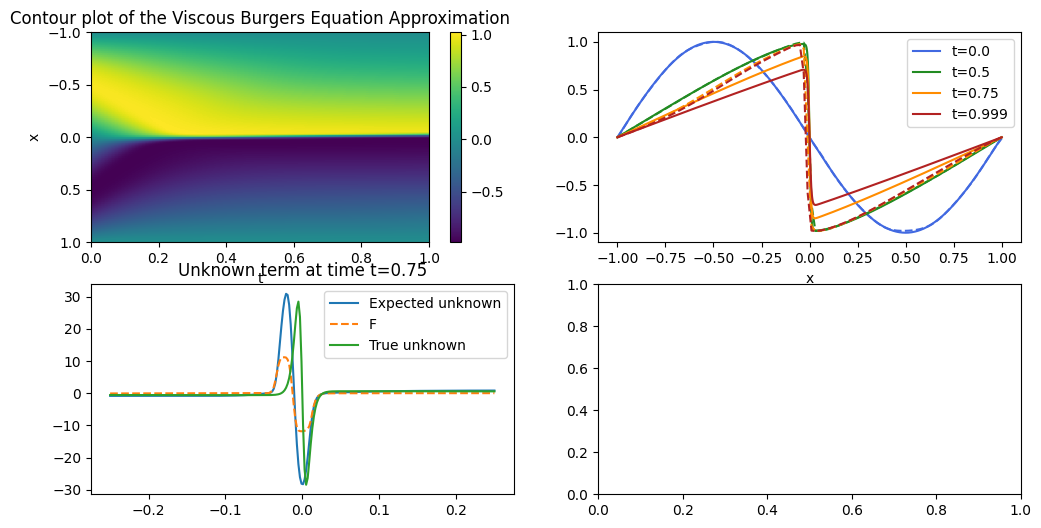

[======              ] 29%[3000/10001]


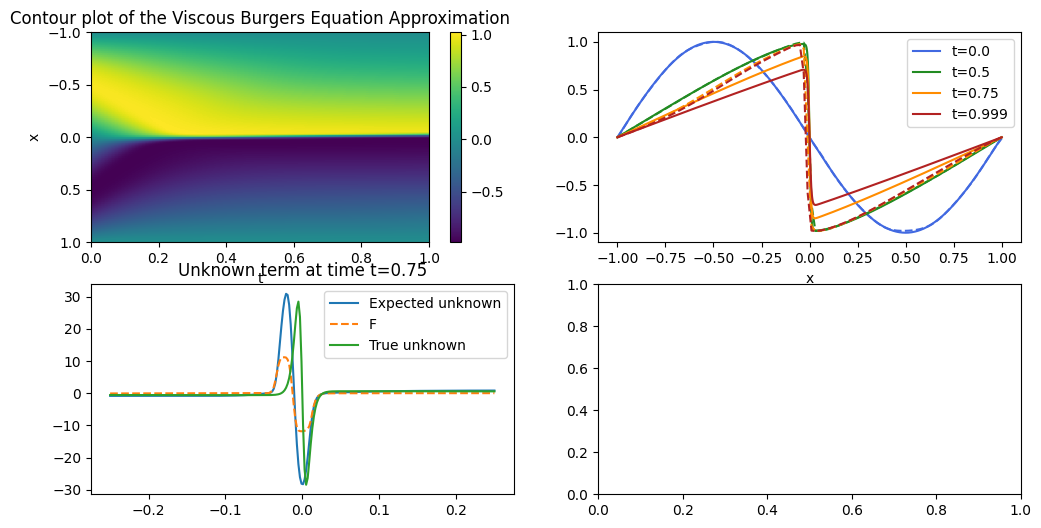

[=======             ] 34%[3500/10001]


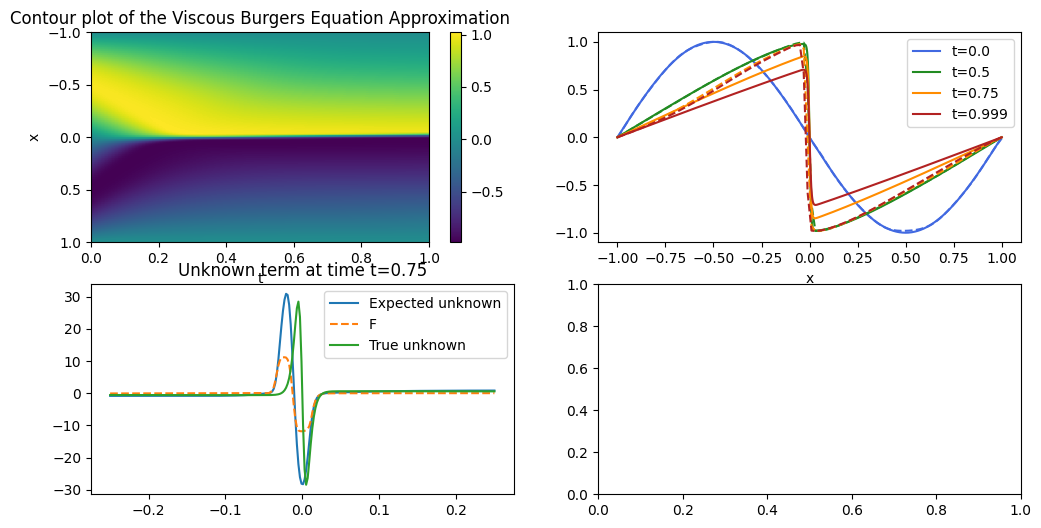

[========            ] 39%[4000/10001]


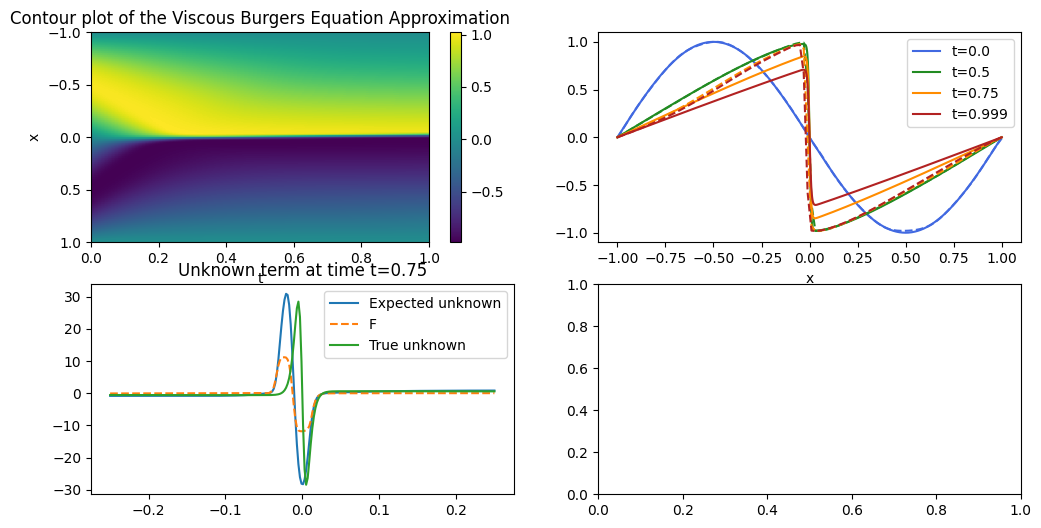

[=========           ] 44%[4500/10001]


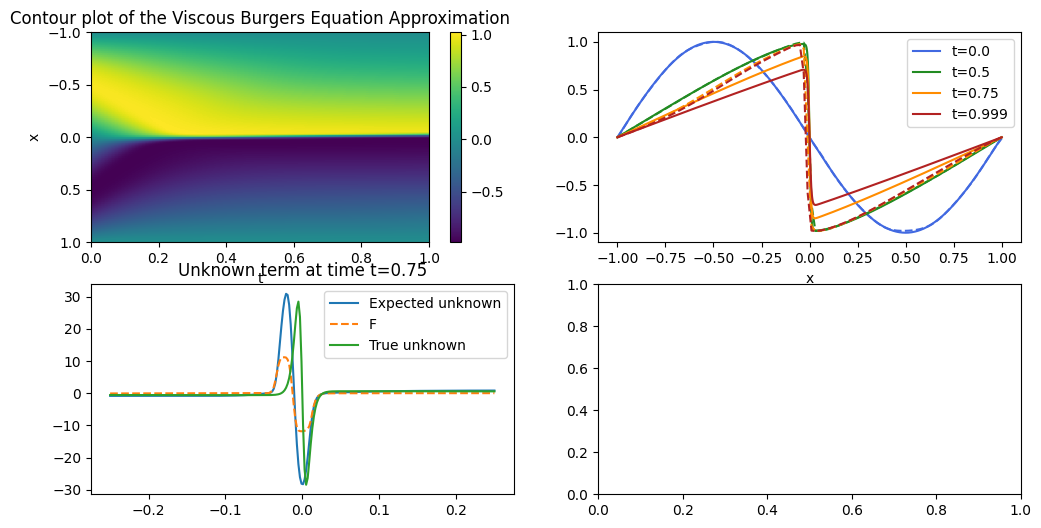

[==========          ] 49%[5000/10001]


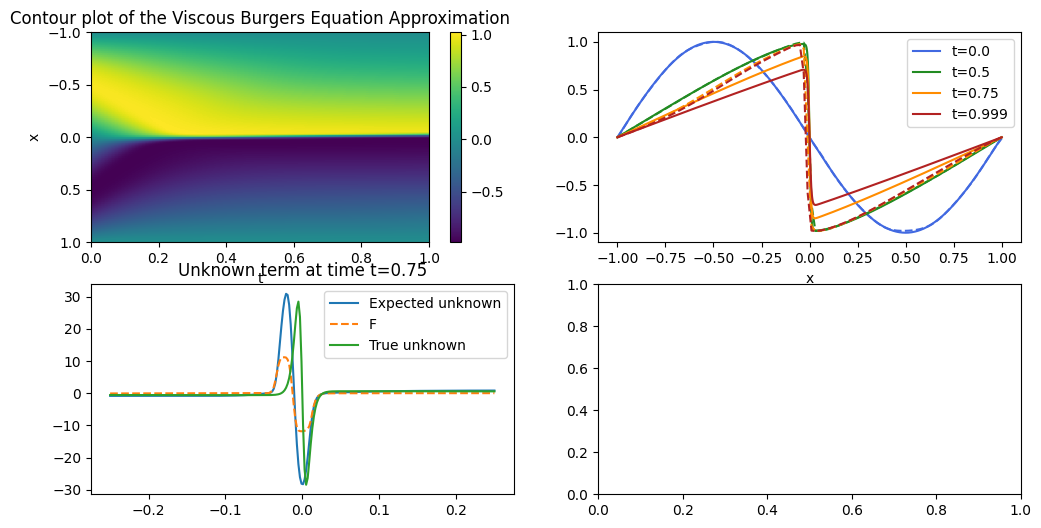

[===========         ] 54%[5500/10001]


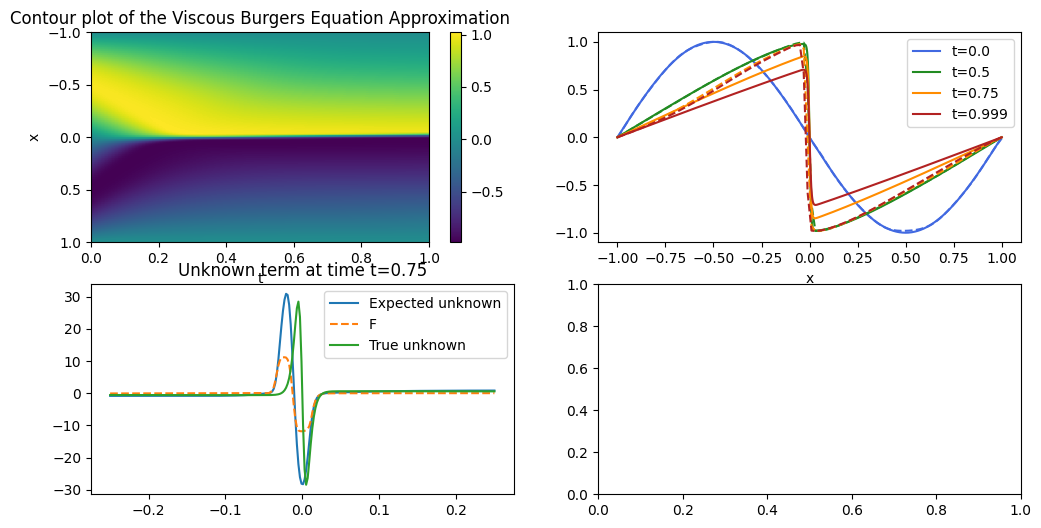

[============        ] 59%[6000/10001]


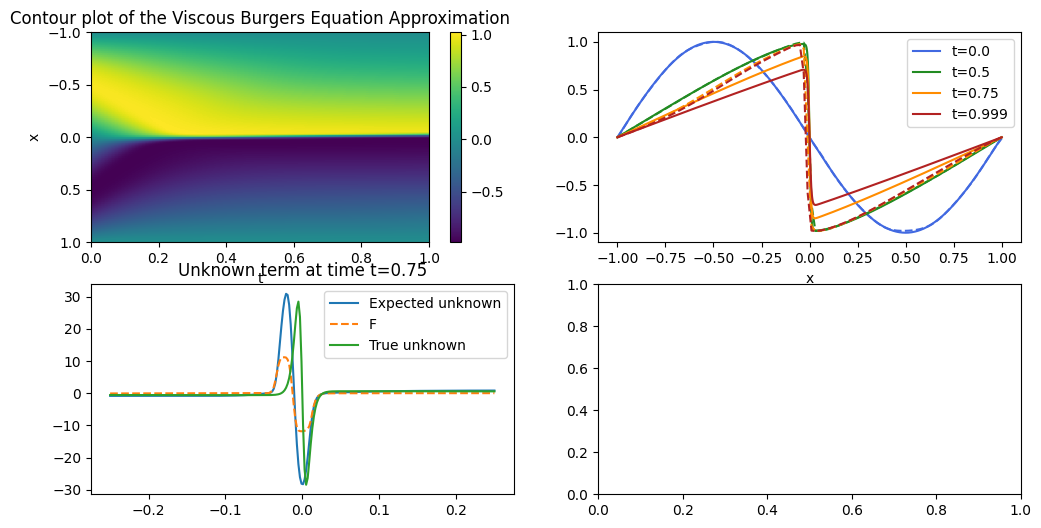

[=============       ] 64%[6500/10001]


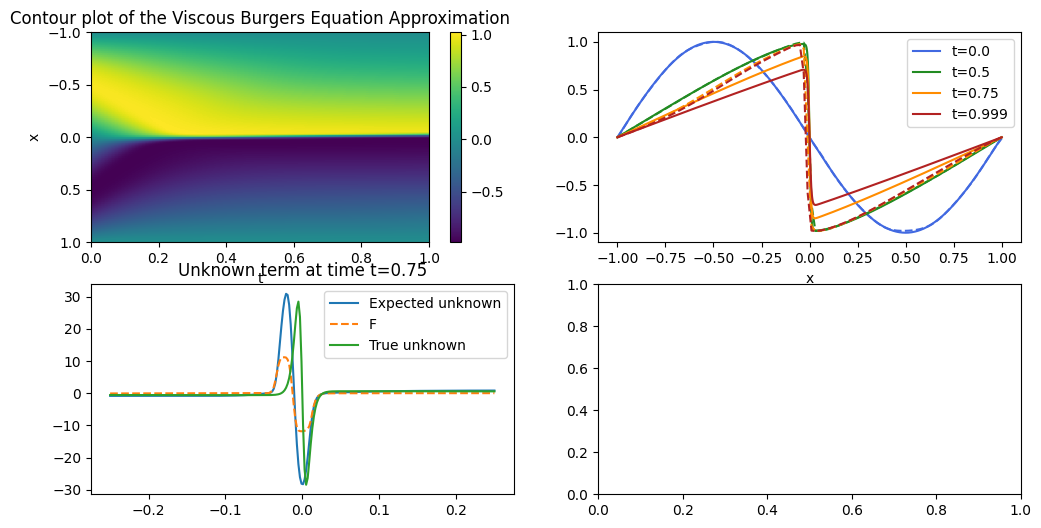

[==============      ] 69%[7000/10001]


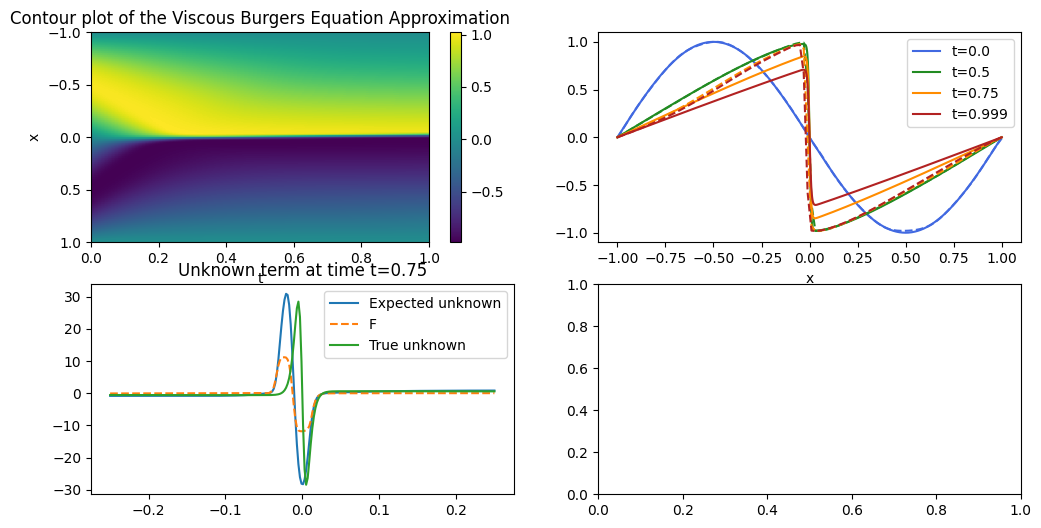

[===============     ] 74%[7500/10001]


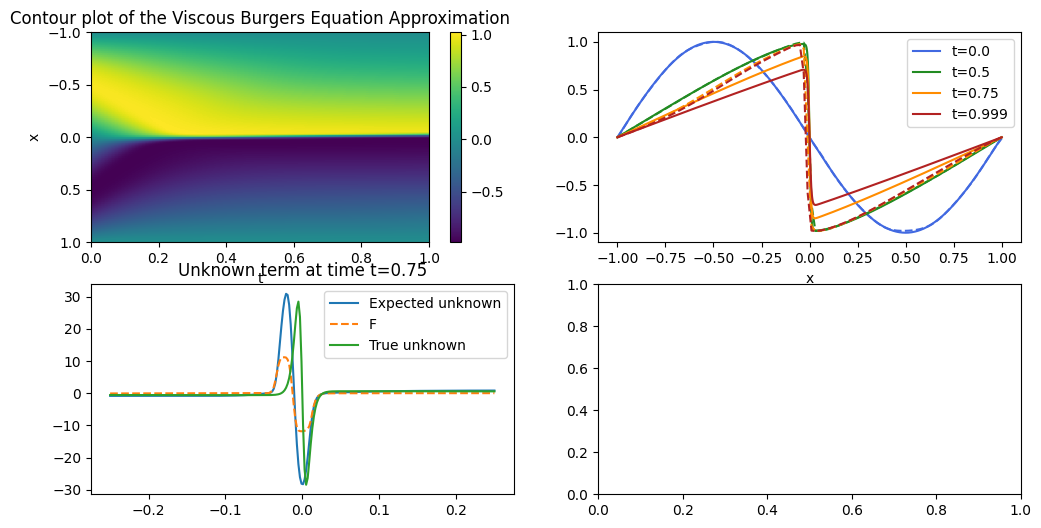

[================    ] 79%[8000/10001]


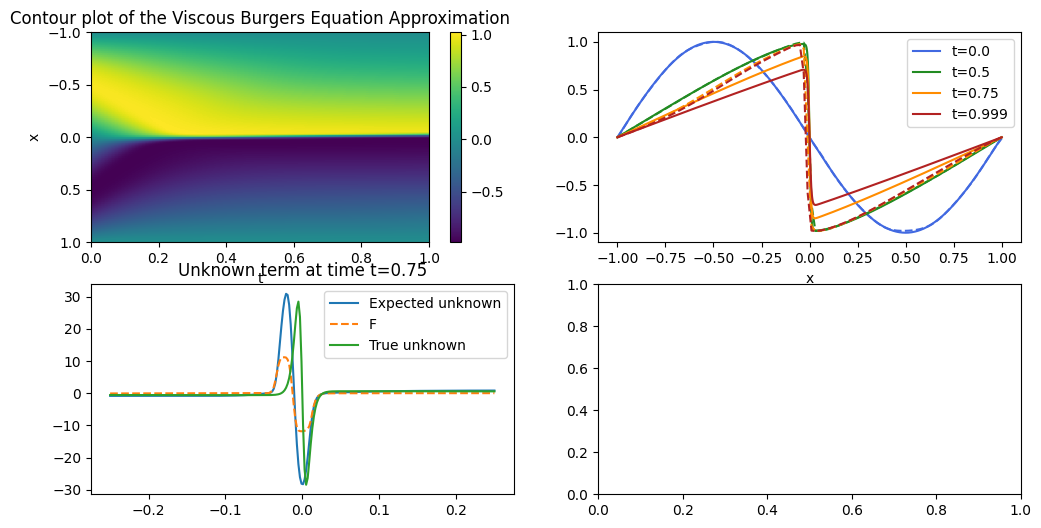

[=================   ] 84%[8500/10001]


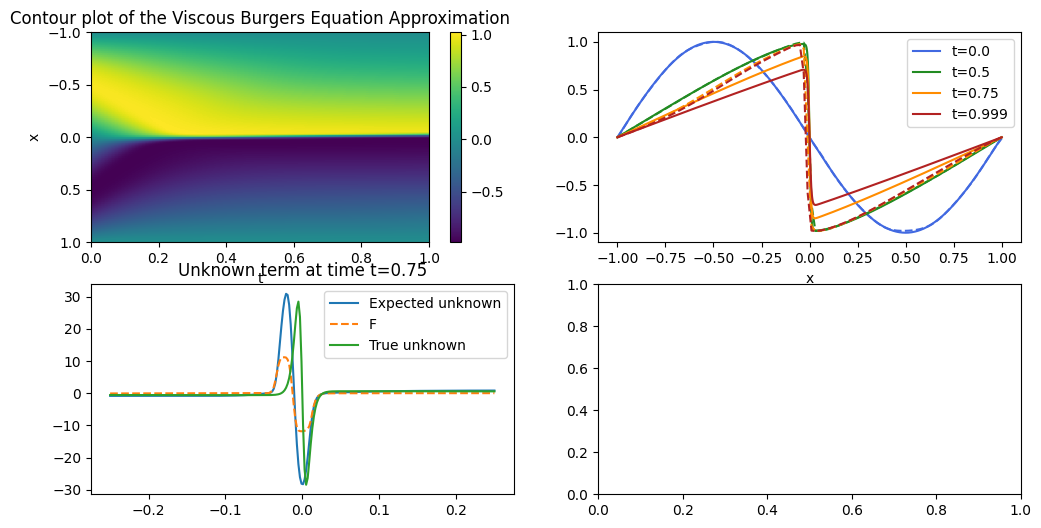

[==================  ] 89%[9000/10001]


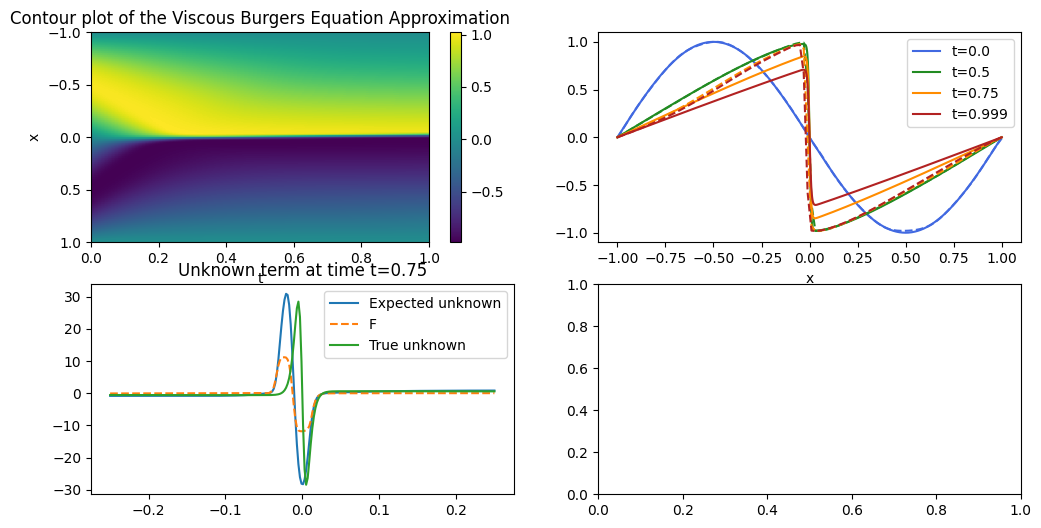

[=================== ] 94%[9500/10001]


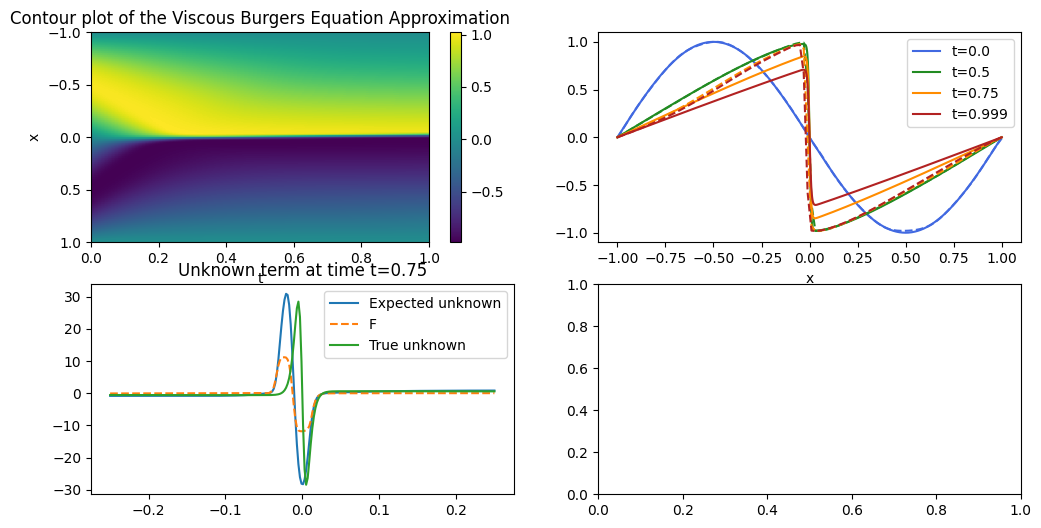

[====================] 99%[10000/10001]


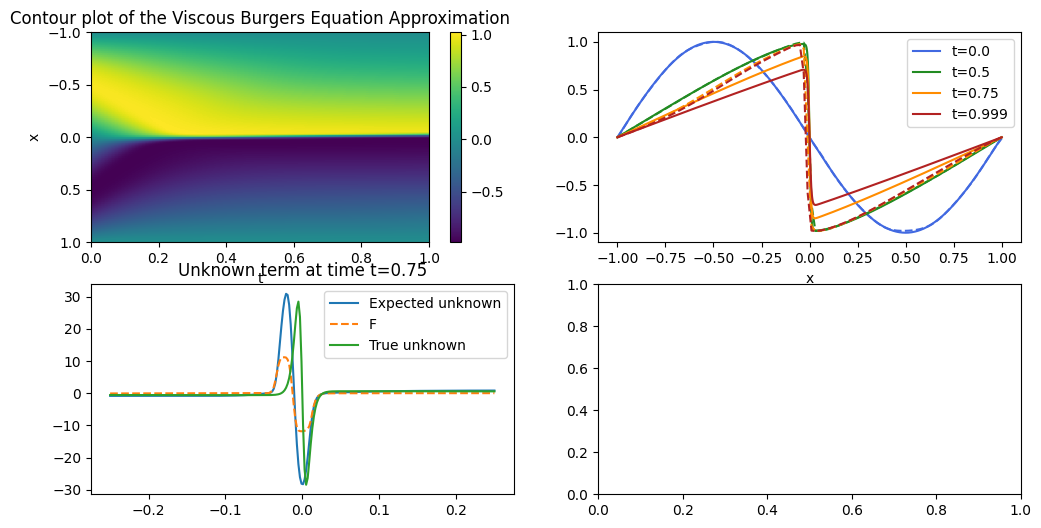

In [ ]:
import sys
lbfgs_itr = 10001


for i in range(lbfgs_itr):
    lbfgs_optim.step(closure)
    sys.stdout.write("\r[%-20s] %d%%" % ('=' * (i // (lbfgs_itr // 20)), (i * 100) // lbfgs_itr))
    sys.stdout.flush()
    
    if i%500 == 0:
        print(f'[{i}/{lbfgs_itr}]')
        fig_lbfgs = plot_solution(usol, u, f)

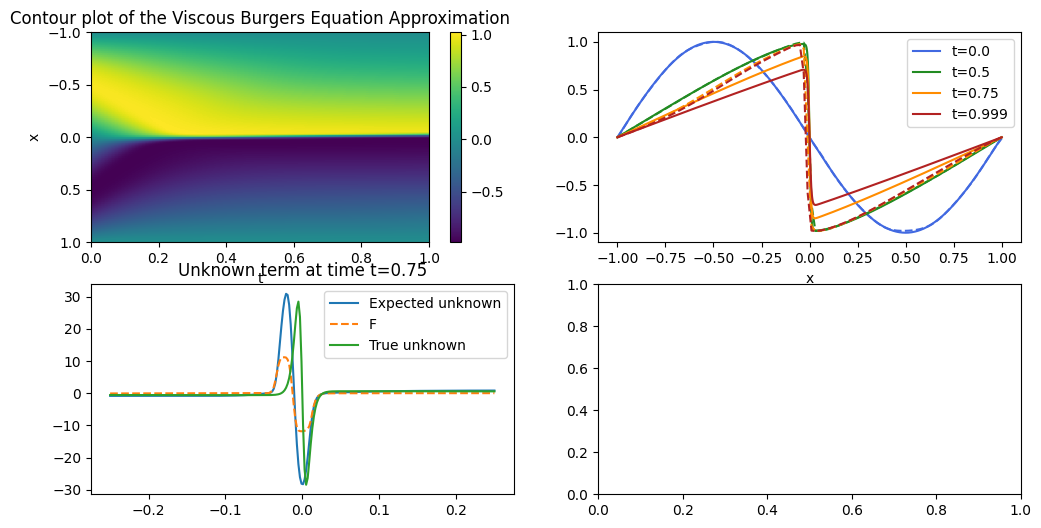

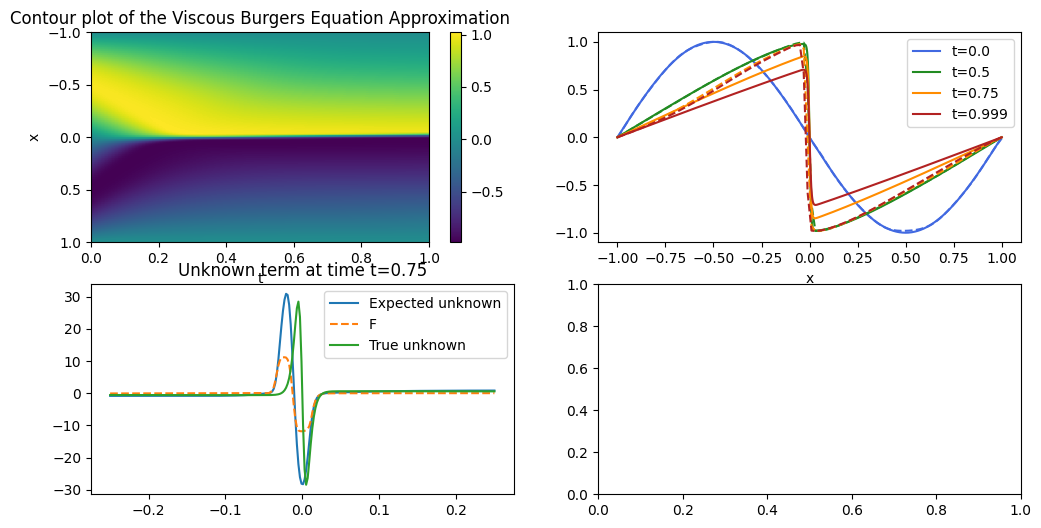

In [ ]:
plot_solution(usol, u, f)

In [ ]:
# Save models
torch.save(u.state_dict(), './u_burgers_LBFGS_good.pt')
torch.save(f.state_dict(), './f_burgers_LBFGS_good.pt')

In [ ]:
fig_lbfgs.savefig('./burgers_lbfgs_good.pdf')

In [ ]:
# how to: Retrieve the model: 

# u_model = U(2,1, [20]*8)
# checkpoint = torch.load('./path/u_burgers_LBFGS.pt')
# u_model.load_state_dict(checkpoint)# u_model.eval()

# equivalent for f

# try it:
# u_model(torch.Tensor([0,-0.5]))

In [ ]:
# plot_solution(usol, u, f, mesh_size=10**2)

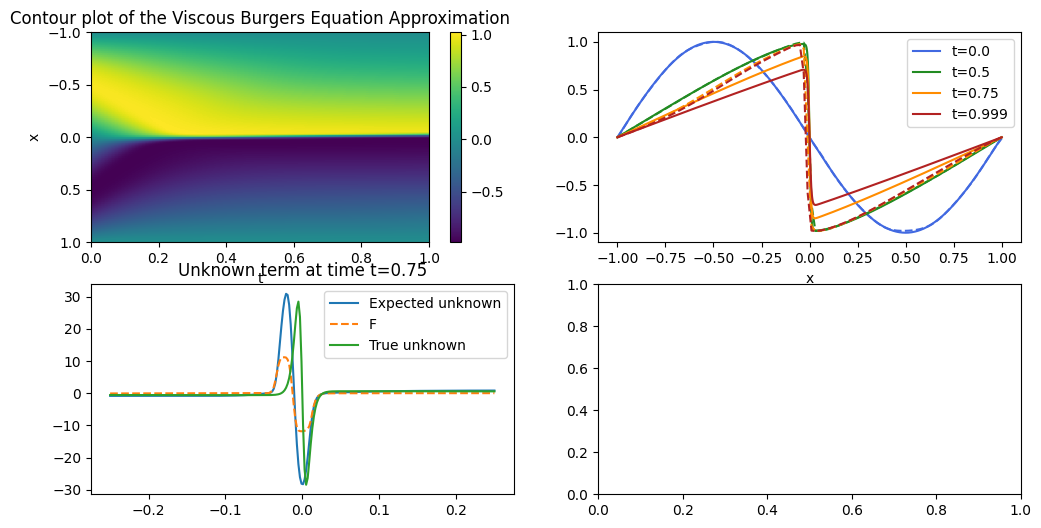

In [ ]:
tmp = plot_solution(usol, u, f,mesh_size=10**2)